## Goal: 
- In this notebook, I will conduct EDA to find any patterns that help segment customers, identify churn indicators, and help build a more usable dataset for modeling. 
- Customer churn represents lost lifetime value and increased acquisition costs.
- The objective of this project is to build a churn risk scoring system that
identifies high-risk customers early enough for targeted retention campaigns. 

## Data:
- Rows: 5,630
- Target Variable: Churn

## Business Relevance:
Accurate churn prediction allows marketing teams to:
1. Target high-risk customers
2. Reduce acquisition costs
3. Improve customer lifetime value



In [1]:
#import neccessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
#read xlsx
cust_df = cust_df = pd.read_excel("../data/ecommerce_churn.xlsx", sheet_name="E Comm")
cust_df.head(10)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60
5,50006,1,0.0,Computer,1,22.0,Debit Card,Female,3.0,5,Mobile Phone,5,Single,2,1,22.0,4.0,6.0,7.0,139.19
6,50007,1,NaN,Phone,3,11.0,Cash on Delivery,Male,2.0,3,Laptop & Accessory,2,Divorced,4,0,14.0,0.0,1.0,0.0,120.86
7,50008,1,NaN,Phone,1,6.0,CC,Male,3.0,3,Mobile,2,Divorced,3,1,16.0,2.0,2.0,0.0,122.93
8,50009,1,13.0,Phone,3,9.0,E wallet,Male,NaN,4,Mobile,3,Divorced,2,1,14.0,0.0,1.0,2.0,126.83
9,50010,1,NaN,Phone,1,31.0,Debit Card,Male,2.0,5,Mobile,3,Single,2,0,12.0,1.0,1.0,1.0,122.93


## Initial Data Audit

Before analysis, perform a high-level audit to understand dataset size,
data types, and missing values.


In [3]:
#check for missing values
cust_df.isna().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

## Distribution Analysis for Variables with Missing Values:

Before imputing missing values, distributions of affected variables
are analyzed to understand skewness, outliers, and appropriate
imputation strategies.


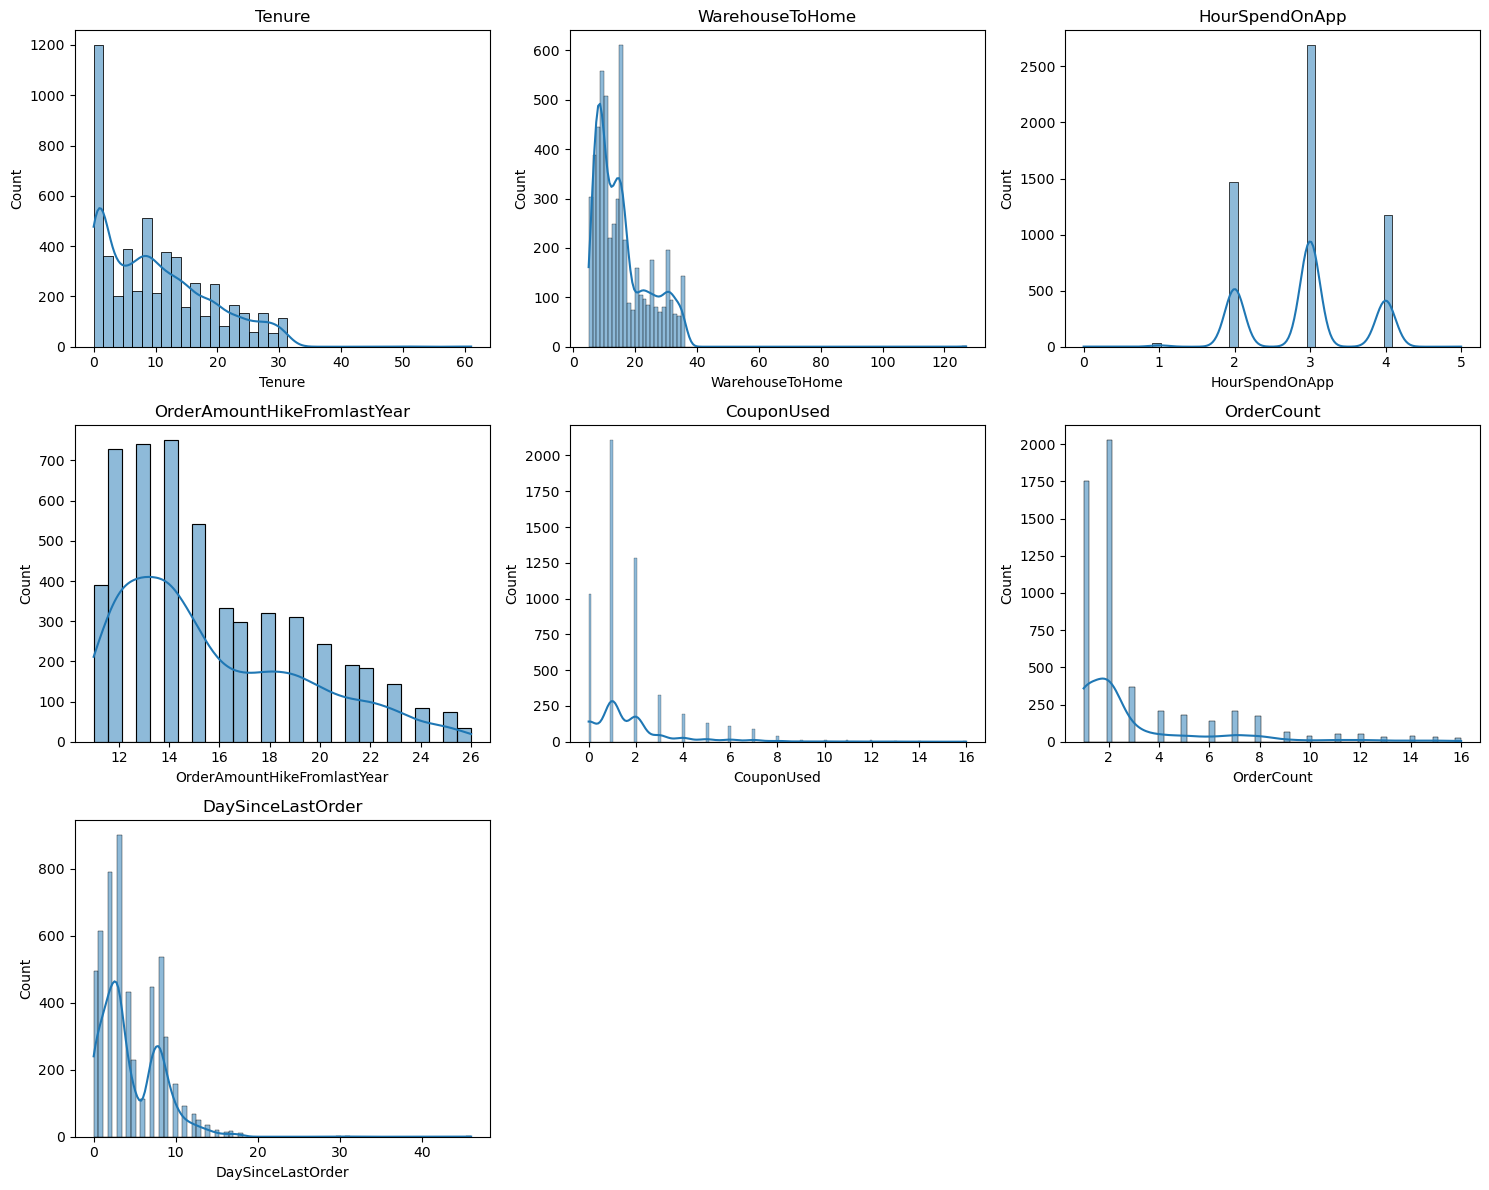

In [4]:
missing_cols = [col for col in cust_df.columns if cust_df[col].isna().sum() > 0]

num_cols = missing_cols
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(15, 4 * n_rows))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(cust_df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


## Missing Value Treatment Strategy

Based on distribution and business interpretation:

- Skewed continuous variables were imputed using the median to reduce
  sensitivity to outliers/noise.
- Discrete variables with business-meaningful zeros were imputed using zero.
- Also add flag for modeling that inidcates records with missing values


In [5]:
#add flag before imputing for modeling signal
for col in missing_cols:
    cust_df[f"{col}_missing"] = cust_df[col].isna().astype(int)

#impute with median for skewed columns
median_cols = [
    "Tenure",
    "WarehouseToHome",
    "HourSpendOnApp",
    "OrderAmountHikeFromlastYear",
    "OrderCount",
    "DaySinceLastOrder"
]

for col in median_cols:
    cust_df[col] = cust_df[col].fillna(cust_df[col].median())

#zero imputation where missing implies no usage
cust_df["CouponUsed"].fillna(0, inplace=True)

C:\Users\wesle\AppData\Local\Temp\ipykernel_34108\4273693926.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cust_df["CouponUsed"].fillna(0, inplace=True)


In [6]:
#check dtypes and make sure all nulls imputed
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 27 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   CustomerID                           5630 non-null   int64  
 1   Churn                                5630 non-null   int64  
 2   Tenure                               5630 non-null   float64
 3   PreferredLoginDevice                 5630 non-null   object 
 4   CityTier                             5630 non-null   int64  
 5   WarehouseToHome                      5630 non-null   float64
 6   PreferredPaymentMode                 5630 non-null   object 
 7   Gender                               5630 non-null   object 
 8   HourSpendOnApp                       5630 non-null   float64
 9   NumberOfDeviceRegistered             5630 non-null   int64  
 10  PreferedOrderCat                     5630 non-null   object 
 11  SatisfactionScore             

## EDA for modeling

Analyze the relationship between customer features and churn to identify
behavioral patterns and guide feature selection and modeling decisions.


In [7]:
#check for class imbalance in target variable 
cust_df['Churn'].value_counts(normalize = True)

Churn
0    0.831616
1    0.168384
Name: proportion, dtype: float64

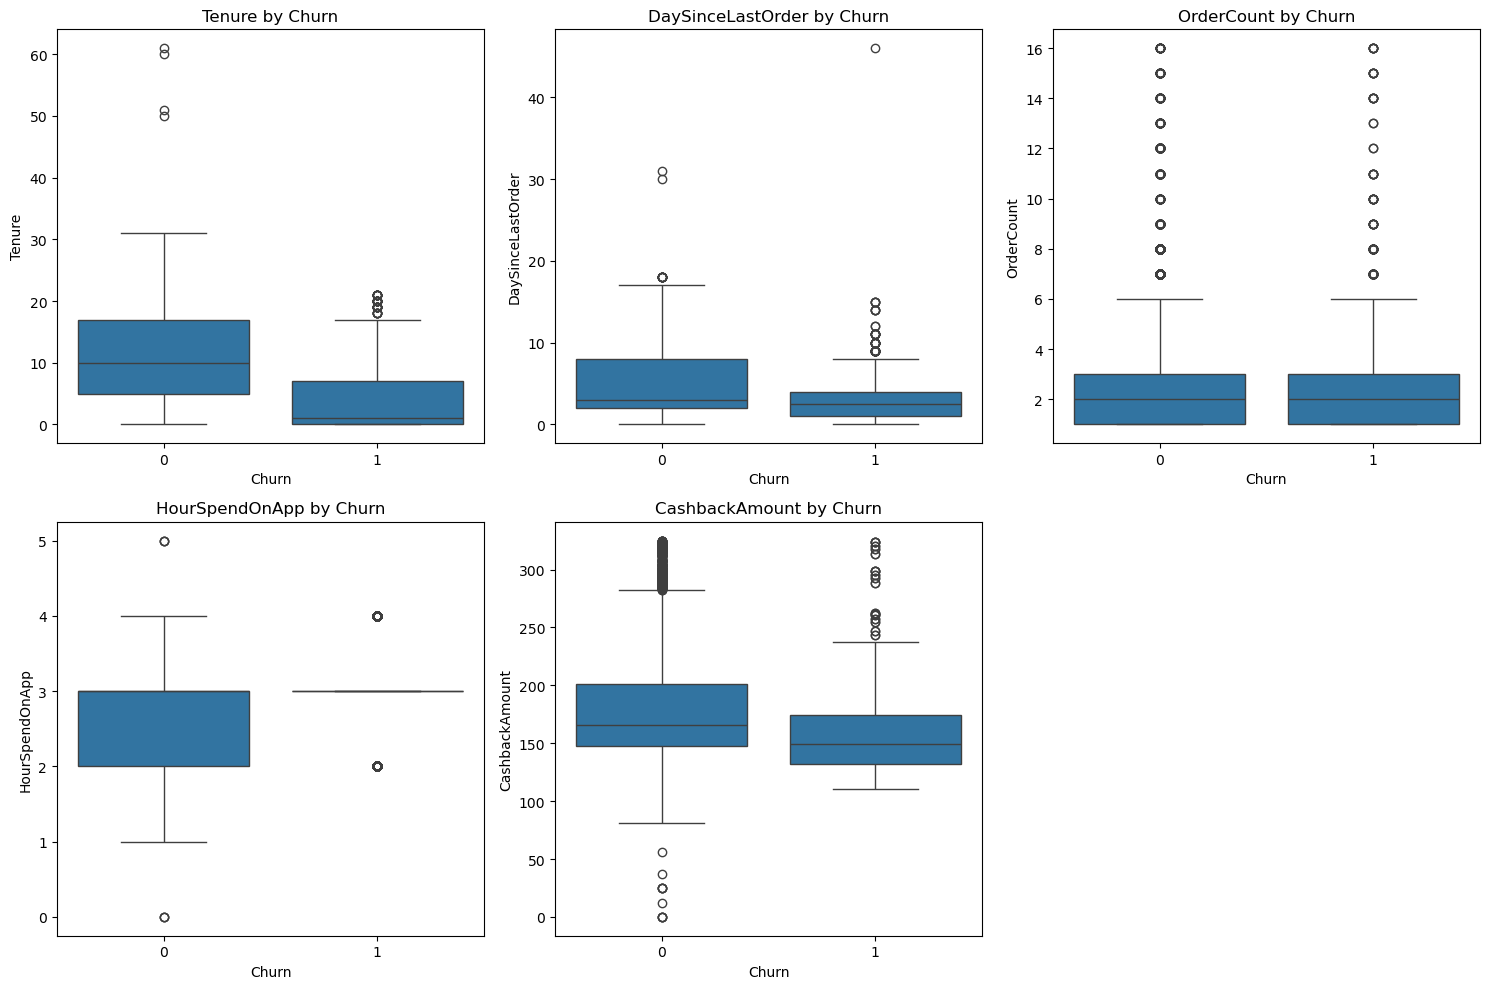

In [8]:
#no extreme class imbalance so lets move on to finding relationships between numerical features vs churn
num_cols = [
    "Tenure",
    "DaySinceLastOrder",
    "OrderCount",
    "HourSpendOnApp",
    "CashbackAmount"
]

n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(15, 5 * n_rows))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x="Churn", y=col, data=cust_df)
    plt.title(f"{col} by Churn")
plt.tight_layout()
plt.show()

## Numerical Feature EDA Summary

Churned customers exhibit significantly lower tenure and higher inactivity,
indicating that newer and less recently active users are at elevated risk of
churn. Engagement-related features (order count, app usage, cashback) show
more nuanced patterns with substantial overlap between churned and retained
customers, suggesting non-linear effects and interaction with recency and
tenure rather than standalone predictive power.


## Categorical Features vs Churn

Analyze churn rates across customer segments to identify high-risk groups
and segment-level patterns.


In [9]:
#lets build a table to show average churn rates across individual le
cat_cols = [
    "Complain",
    "PreferredLoginDevice",
    "PreferredPaymentMode",
    "PreferedOrderCat",
    "CityTier"
]

for col in cat_cols:
    churn_rate = cust_df.groupby(col)["Churn"].mean().sort_values(ascending=False)
    print(f"\nChurn rate by {col}:")
    display(churn_rate)



Churn rate by Complain:


Complain
1    0.316708
0    0.109290
Name: Churn, dtype: float64


Churn rate by PreferredLoginDevice:


PreferredLoginDevice
Phone           0.224208
Computer        0.198286
Mobile Phone    0.125859
Name: Churn, dtype: float64


Churn rate by PreferredPaymentMode:


PreferredPaymentMode
COD                 0.287671
E wallet            0.228013
CC                  0.216117
UPI                 0.173913
Cash on Delivery    0.154362
Debit Card          0.153846
Credit Card         0.128581
Name: Churn, dtype: float64


Churn rate by PreferedOrderCat:


PreferedOrderCat
Mobile Phone          0.275374
Mobile                0.271941
Fashion               0.154964
Laptop & Accessory    0.102439
Others                0.075758
Grocery               0.048780
Name: Churn, dtype: float64


Churn rate by CityTier:


CityTier
3    0.213705
2    0.198347
1    0.145117
Name: Churn, dtype: float64

## Categorical Feature EDA Summary

Customers who have filed complaints exhibit substantially higher churn rates,
making service experience a dominant churn driver. Churn also varies by order
category and payment behavior, with higher churn observed in discretionary
product categories and less committed payment methods. Platform usage and
city tier show moderate effects, suggesting segment-level differences in
retention risk.
